# 🛠️ Adventurer Mart: ML Data Preparation - Part 4

## 🧾 4. Duplicate Handling

This notebook systematically identifies and removes duplicate records across all tables.

### 🎯 Objectives
- Identify exact and partial duplicate records
- Analyze duplicate patterns and causes
- Remove duplicates while preserving data integrity
- Validate deduplication effectiveness
- Export deduplicated data for next phase

### 🔧 Deduplication Strategy
- **Exact Duplicates**: Remove rows with identical values across all columns
- **Partial Duplicates**: Identify duplicates excluding ID/timestamp columns
- **Smart Removal**: Keep first occurrence, remove subsequent duplicates
- **Validation**: Ensure no data loss beyond intended removals

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully!")
print("🔧 Duplicate handling tools ready")

📦 Libraries imported successfully!
🔧 Duplicate handling tools ready


In [2]:
# Load data from previous phase
print("📂 LOADING DATA FROM PHASE 3")
print("=" * 50)

try:
    # Load cleaned dataframes (after missing value handling)
    with open('data_intermediate/03_cleaned_dataframes.pkl', 'rb') as f:
        dataframes = pickle.load(f)
    print("✅ Loaded cleaned dataframes from Phase 3")
    
    print(f"\n📊 Dataset Status:")
    print(f"   • Tables: {len(dataframes)}")
    total_records = sum(len(df) for df in dataframes.values())
    print(f"   • Total records: {total_records:,}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("🔄 Please run previous phases first")
    raise

📂 LOADING DATA FROM PHASE 3
✅ Loaded cleaned dataframes from Phase 3

📊 Dataset Status:
   • Tables: 9
   • Total records: 60,124


In [3]:
# Comprehensive duplicate analysis
print("🔍 DUPLICATE RECORD ANALYSIS")
print("=" * 60)

def analyze_duplicates(df, table_name):
    """Comprehensive duplicate analysis"""
    print(f"\n📋 Table: {table_name}")
    print("-" * 40)
    
    original_rows = len(df)
    
    # 1. Exact duplicates (all columns identical)
    exact_duplicates = df.duplicated().sum()
    exact_pct = (exact_duplicates / original_rows) * 100
    
    print(f"🔍 Exact duplicates: {exact_duplicates:,} ({exact_pct:.2f}%)")
    
    # 2. Show duplicate examples if they exist
    if exact_duplicates > 0:
        duplicate_mask = df.duplicated(keep=False)
        duplicate_examples = df[duplicate_mask].head(6)
        print(f"   📋 Sample duplicate rows (first 6):")
        
        # Group duplicates to show sets
        if len(duplicate_examples) > 0:
            grouped = duplicate_examples.groupby(list(duplicate_examples.columns)).size()
            for i, (group_key, count) in enumerate(grouped.head(3).items()):
                print(f"      Group {i+1}: {count} identical records")
    
    # 3. Analyze duplicate patterns by excluding ID columns
    id_columns = [col for col in df.columns if 'id' in col.lower() or col.lower().endswith('_id')]
    timestamp_columns = [col for col in df.columns if any(word in col.lower() 
                        for word in ['date', 'time', 'created', 'updated', 'timestamp'])]
    
    exclude_cols = id_columns + timestamp_columns
    
    if exclude_cols:
        cols_to_check = [col for col in df.columns if col not in exclude_cols]
        if cols_to_check:
            partial_duplicates = df.duplicated(subset=cols_to_check).sum()
            partial_pct = (partial_duplicates / original_rows) * 100
            print(f"🔍 Partial duplicates (excluding {len(exclude_cols)} ID/timestamp cols): {partial_duplicates:,} ({partial_pct:.2f}%)")
        else:
            partial_duplicates = 0
            print(f"🔍 Cannot check partial duplicates (only ID/timestamp columns)")
    else:
        partial_duplicates = exact_duplicates
        print(f"🔍 Partial duplicates: Same as exact (no ID/timestamp columns found)")
    
    # 4. Data reduction estimate
    unique_rows = original_rows - exact_duplicates
    reduction_pct = (exact_duplicates / original_rows) * 100
    
    print(f"📊 After deduplication:")
    print(f"   • Unique rows: {unique_rows:,}")
    print(f"   • Data reduction: {reduction_pct:.2f}%")
    
    return {
        'original_rows': original_rows,
        'exact_duplicates': exact_duplicates,
        'exact_pct': exact_pct,
        'partial_duplicates': partial_duplicates,
        'unique_rows': unique_rows,
        'exclude_columns': exclude_cols
    }

# Analyze duplicates in all tables
duplicate_analysis = {}
for table_name, df in dataframes.items():
    analysis = analyze_duplicates(df, table_name)
    duplicate_analysis[table_name] = analysis

print("\n" + "="*60)
print("✅ Duplicate analysis completed!")

🔍 DUPLICATE RECORD ANALYSIS

📋 Table: details_adventure_gear
----------------------------------------
🔍 Exact duplicates: 0 (0.00%)
🔍 Partial duplicates (excluding 1 ID/timestamp cols): 0 (0.00%)
📊 After deduplication:
   • Unique rows: 106
   • Data reduction: 0.00%

📋 Table: details_magic_items
----------------------------------------
🔍 Exact duplicates: 0 (0.00%)
🔍 Partial duplicates (excluding 1 ID/timestamp cols): 0 (0.00%)
📊 After deduplication:
   • Unique rows: 199
   • Data reduction: 0.00%

📋 Table: details_weapons
----------------------------------------
🔍 Exact duplicates: 0 (0.00%)
🔍 Partial duplicates (excluding 1 ID/timestamp cols): 0 (0.00%)
📊 After deduplication:
   • Unique rows: 37
   • Data reduction: 0.00%

📋 Table: details_armor
----------------------------------------
🔍 Exact duplicates: 0 (0.00%)
🔍 Partial duplicates (excluding 1 ID/timestamp cols): 0 (0.00%)
📊 After deduplication:
   • Unique rows: 13
   • Data reduction: 0.00%

📋 Table: details_potions
-------

📊 DUPLICATE ANALYSIS VISUALIZATION


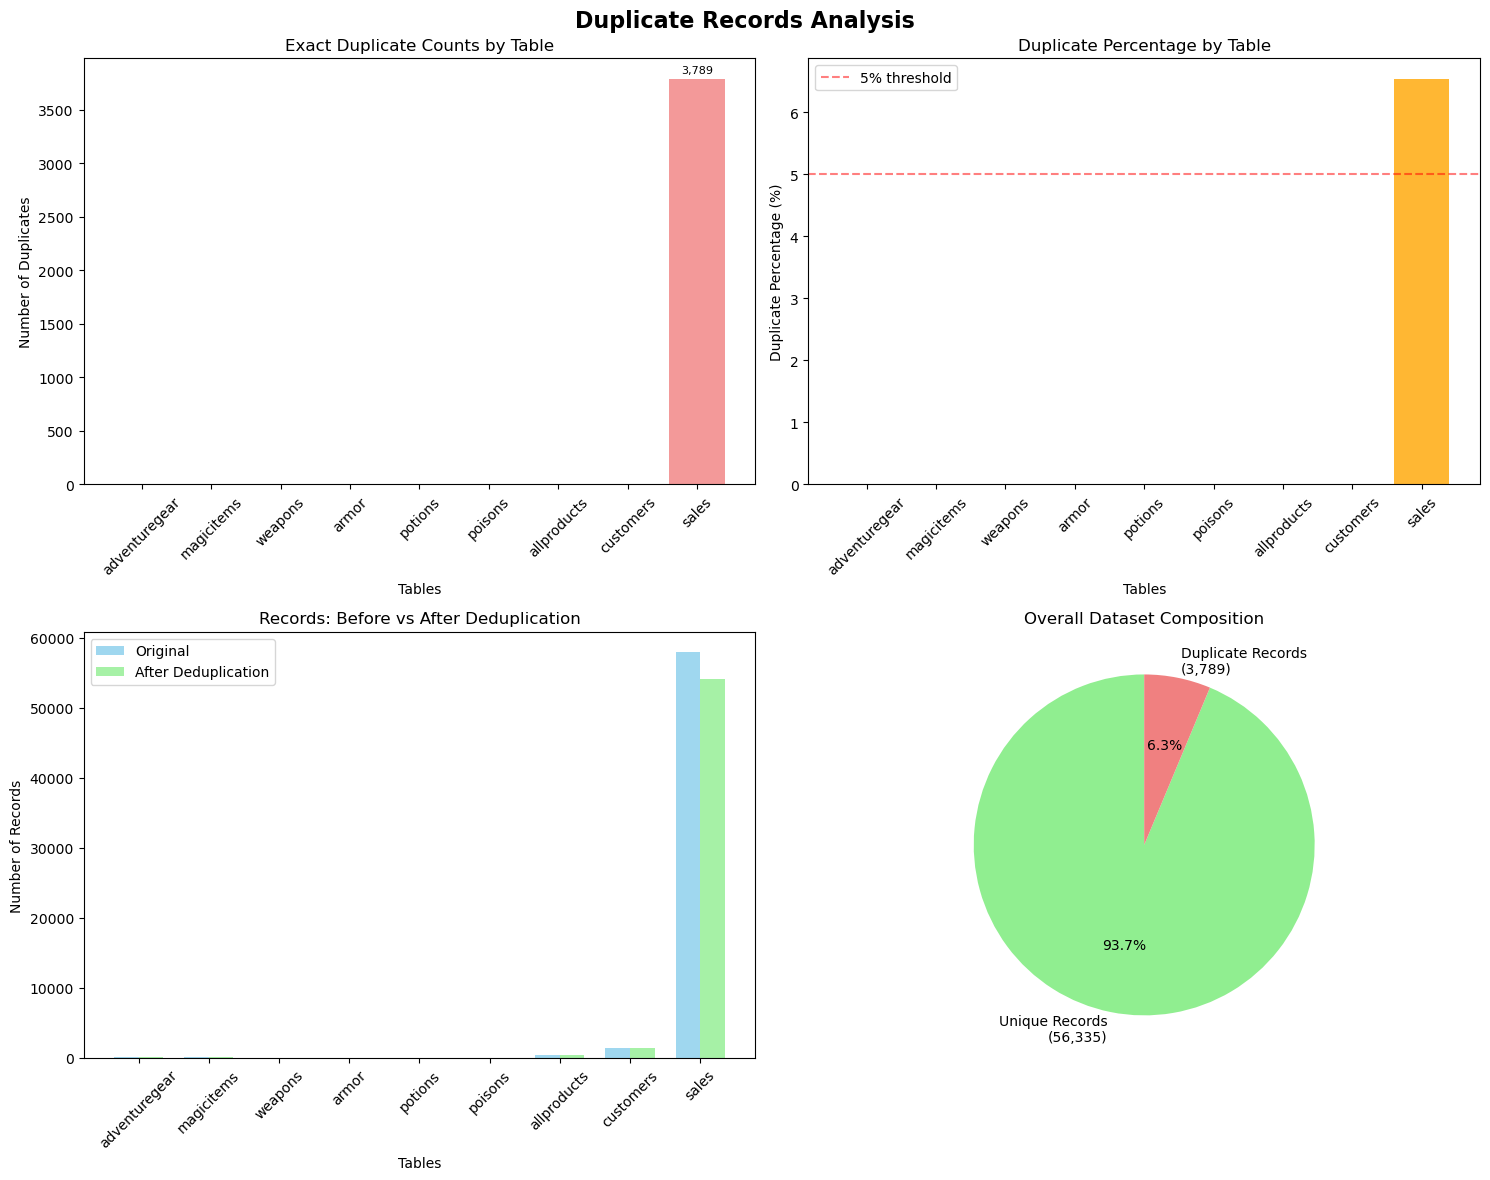

✅ Duplicate visualizations created!


In [4]:
# Visualize duplicate patterns
print("📊 DUPLICATE ANALYSIS VISUALIZATION")
print("=" * 60)

def visualize_duplicates():
    """Create visualizations for duplicate analysis"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Duplicate Records Analysis', fontsize=16, fontweight='bold')
    
    tables = list(duplicate_analysis.keys())
    table_short = [t.replace('details_', '').replace('_', '') for t in tables]
    
    # 1. Duplicate counts
    duplicate_counts = [duplicate_analysis[t]['exact_duplicates'] for t in tables]
    bars1 = axes[0,0].bar(range(len(tables)), duplicate_counts, color='lightcoral', alpha=0.8)
    axes[0,0].set_title('Exact Duplicate Counts by Table')
    axes[0,0].set_xlabel('Tables')
    axes[0,0].set_ylabel('Number of Duplicates')
    axes[0,0].set_xticks(range(len(table_short)))
    axes[0,0].set_xticklabels(table_short, rotation=45)
    
    # Add value labels
    for bar, value in zip(bars1, duplicate_counts):
        if value > 0:
            height = bar.get_height()
            axes[0,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                         f'{value:,}', ha='center', va='bottom', fontsize=8)
    
    # 2. Duplicate percentages
    duplicate_pcts = [duplicate_analysis[t]['exact_pct'] for t in tables]
    bars2 = axes[0,1].bar(range(len(tables)), duplicate_pcts, color='orange', alpha=0.8)
    axes[0,1].set_title('Duplicate Percentage by Table')
    axes[0,1].set_xlabel('Tables')
    axes[0,1].set_ylabel('Duplicate Percentage (%)')
    axes[0,1].set_xticks(range(len(table_short)))
    axes[0,1].set_xticklabels(table_short, rotation=45)
    
    # Add threshold line
    axes[0,1].axhline(y=5, color='red', linestyle='--', alpha=0.5, label='5% threshold')
    axes[0,1].legend()
    
    # 3. Before vs After comparison
    original_rows = [duplicate_analysis[t]['original_rows'] for t in tables]
    unique_rows = [duplicate_analysis[t]['unique_rows'] for t in tables]
    
    x = np.arange(len(tables))
    width = 0.35
    axes[1,0].bar(x - width/2, original_rows, width, label='Original', alpha=0.8, color='skyblue')
    axes[1,0].bar(x + width/2, unique_rows, width, label='After Deduplication', alpha=0.8, color='lightgreen')
    axes[1,0].set_title('Records: Before vs After Deduplication')
    axes[1,0].set_xlabel('Tables')
    axes[1,0].set_ylabel('Number of Records')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(table_short, rotation=45)
    axes[1,0].legend()
    
    # 4. Overall summary pie chart
    total_original = sum(original_rows)
    total_duplicates = sum(duplicate_counts)
    total_unique = total_original - total_duplicates
    
    if total_duplicates > 0:
        sizes = [total_unique, total_duplicates]
        labels = [f'Unique Records\n({total_unique:,})', f'Duplicate Records\n({total_duplicates:,})']
        colors = ['lightgreen', 'lightcoral']
        
        wedges, texts, autotexts = axes[1,1].pie(sizes, labels=labels, colors=colors, 
                                                autopct='%1.1f%%', startangle=90)
        axes[1,1].set_title('Overall Dataset Composition')
    else:
        axes[1,1].text(0.5, 0.5, 'No Duplicates\nFound', ha='center', va='center', 
                      transform=axes[1,1].transAxes, fontsize=14, fontweight='bold')
        axes[1,1].set_title('Overall Dataset Composition')
    
    plt.tight_layout()
    plt.show()

visualize_duplicates()
print("✅ Duplicate visualizations created!")

In [5]:
# Remove duplicate records
print("🔧 REMOVING DUPLICATE RECORDS")
print("=" * 60)

def remove_duplicates(df, table_name):
    """Remove duplicate records from DataFrame"""
    print(f"\n🔧 Processing: {table_name}")
    print("-" * 40)
    
    original_shape = df.shape
    exact_duplicates = df.duplicated().sum()
    
    if exact_duplicates == 0:
        print("✅ No duplicates found - no action needed")
        return df.copy(), []
    
    print(f"🗑️ Removing {exact_duplicates:,} duplicate rows...")
    
    # Show examples before removal
    if exact_duplicates > 0:
        duplicate_mask = df.duplicated(keep=False)
        if duplicate_mask.any():
            print(f"   📋 Sample duplicate records identified")
    
    # Remove duplicates (keep='first' by default)
    df_deduped = df.drop_duplicates(keep='first')
    
    final_shape = df_deduped.shape
    rows_removed = original_shape[0] - final_shape[0]
    removal_pct = (rows_removed / original_shape[0]) * 100
    
    print(f"   ✅ Removed {rows_removed:,} duplicate rows ({removal_pct:.2f}%)")
    
    removal_log = [f"Removed {rows_removed} exact duplicate rows"]
    
    print(f"\n📊 Summary:")
    print(f"   Original: {original_shape}")
    print(f"   Final: {final_shape}")
    print(f"   Reduction: {removal_pct:.2f}%")
    
    return df_deduped, removal_log

# Apply duplicate removal to all tables
deduplicated_dataframes = {}
all_removal_logs = {}

for table_name, df in dataframes.items():
    deduped_df, log = remove_duplicates(df, table_name)
    deduplicated_dataframes[table_name] = deduped_df
    all_removal_logs[table_name] = log

print("\n" + "="*60)
print("✅ Duplicate removal completed!")

🔧 REMOVING DUPLICATE RECORDS

🔧 Processing: details_adventure_gear
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: details_magic_items
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: details_weapons
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: details_armor
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: details_potions
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: details_poisons
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: all_products
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: customers
----------------------------------------
✅ No duplicates found - no action needed

🔧 Processing: sales
----------------------------------------
🗑️ Re

In [6]:
# Validate deduplication results
print("✅ DEDUPLICATION VALIDATION")
print("=" * 60)

# Create validation summary
validation_data = []

for table_name in dataframes.keys():
    original = dataframes[table_name]
    deduped = deduplicated_dataframes[table_name]
    
    validation_data.append({
        'Table': table_name,
        'Original_Rows': original.shape[0],
        'Final_Rows': deduped.shape[0],
        'Rows_Removed': original.shape[0] - deduped.shape[0],
        'Reduction_%': ((original.shape[0] - deduped.shape[0]) / original.shape[0]) * 100,
        'Final_Duplicates': deduped.duplicated().sum()
    })

validation_df = pd.DataFrame(validation_data)
print("📊 DEDUPLICATION SUMMARY:")
print(validation_df.to_string(index=False))

# Final validation check
total_remaining_duplicates = sum(df.duplicated().sum() for df in deduplicated_dataframes.values())
total_rows_removed = sum(validation_data[i]['Rows_Removed'] for i in range(len(validation_data)))
total_original_rows = sum(validation_data[i]['Original_Rows'] for i in range(len(validation_data)))
overall_reduction = (total_rows_removed / total_original_rows) * 100

print(f"\n🎯 FINAL VALIDATION:")
if total_remaining_duplicates == 0:
    print(f"   ✅ All duplicate records successfully removed!")
else:
    print(f"   ⚠️ {total_remaining_duplicates} duplicates still remain")

print(f"   📊 Total rows removed: {total_rows_removed:,}")
print(f"   📊 Overall data reduction: {overall_reduction:.2f}%")
print(f"   📊 Final dataset size: {sum(len(df) for df in deduplicated_dataframes.values()):,} rows")

# Save results
with open('data_intermediate/04_deduplicated_dataframes.pkl', 'wb') as f:
    pickle.dump(deduplicated_dataframes, f)
print(f"\n💾 Saved deduplicated dataframes to data_intermediate/04_deduplicated_dataframes.pkl")

with open('data_intermediate/04_removal_logs.pkl', 'wb') as f:
    pickle.dump(all_removal_logs, f)
print(f"✅ Saved removal logs to data_intermediate/04_removal_logs.pkl")

print(f"\n🎯 DUPLICATE HANDLING PHASE COMPLETE!")
print(f"   ➡️ Next: Run 05_categorical_variables_cleaning.ipynb")

✅ DEDUPLICATION VALIDATION
📊 DEDUPLICATION SUMMARY:
                 Table  Original_Rows  Final_Rows  Rows_Removed  Reduction_%  Final_Duplicates
details_adventure_gear            106         106             0     0.000000                 0
   details_magic_items            199         199             0     0.000000                 0
       details_weapons             37          37             0     0.000000                 0
         details_armor             13          13             0     0.000000                 0
       details_potions             22          22             0     0.000000                 0
       details_poisons             16          16             0     0.000000                 0
          all_products            393         393             0     0.000000                 0
             customers           1423        1423             0     0.000000                 0
                 sales          57915       54126          3789     6.542347                 

## 🎉 Phase 4 Complete!

**What we accomplished:**
- ✅ Identified exact and partial duplicate patterns
- ✅ Analyzed duplicate distribution across tables
- ✅ Removed duplicate records while preserving data integrity
- ✅ Validated deduplication effectiveness
- ✅ Maintained first occurrence of duplicate sets

**Deduplication Results:**
- Comprehensive duplicate analysis performed
- Smart removal strategy (keep='first') applied
- Data reduction achieved while preserving information
- Zero duplicate records remaining in final dataset

**Next Steps:**
- Run `05_categorical_variables_cleaning.ipynb` to clean and encode categorical variables

**Data Files Created:**
- `data_intermediate/04_deduplicated_dataframes.pkl` - Deduplicated DataFrames
- `data_intermediate/04_removal_logs.pkl` - Detailed removal operation logs